# Modelling the Credit Card Fraud Detection Dataset

This notebook demonstrates the steps taken in analysing the credit card fraud detection dataset (CCFD) through exploration, visualisation, and training of the classification model. 

The dataset can be accessed at: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data

## 1. Import Libraries

Import the libraries for fetching and handling the CCFD dataframes, numerical analysis, plotting, and model training and evaluation. 

In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf

## 2. Loading the Dataset

### 2.1 Fetching

Fetch the CCFD data by the dataset_download function of the kagglehub library which communicates with the kaggle API.

In [2]:
# Download the latest version of the dataset
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Jaspi\.cache\kagglehub\datasets\mlg-ulb\creditcardfraud\versions\3


### 2.2 Loading

Load the CCFD data from the local path into a pandas dataframe. We can see from the shape of the dataframe that we have 31 variables and 284807 instances.

In [3]:
file_path = os.path.join(path, "creditcard.csv")

# Check if the file exists
if os.path.exists(file_path):
    # Load the dataset into a pandas DataFrame
    ccfd_df = pd.read_csv(file_path)
    print(f"Dataset loaded successfully with shape: {ccfd_df.shape}")
else:
    raise FileNotFoundError(f"File creditcard.csv not found in path: {path}")

X = ccfd_df.drop(columns=["Class"])
y = ccfd_df["Class"]

Dataset loaded successfully with shape: (284807, 31)


### 2.3 Variable information

The variable information shows us that we have 30 float features, 28 of which are undefined. The remaining two features represent: 
- time of transaction
- amount of transaction

The target variable for this dataset is the class, namely whether the transaction is fraudulent or non-fraudulent. The target variable is represented in this dataset as an integer.

We lastly note that all variables in the dataset are complete, with no missing values.

In [4]:
ccfd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### 2.4 Dataset

We can examine the dataset to get an idea of the structure for our 30 features (including time and amount) and target class variable.

In [5]:
# Set full display of columsn
pd.set_option("display.max_columns", None)

# Display first 10 instances
ccfd_df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,-1.416907,-0.153826,-0.751063,0.167372,0.050144,-0.443587,0.002821,-0.611987,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,-0.619468,0.291474,1.757964,-1.323865,0.686133,-0.076127,-1.222127,-0.358222,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,-0.705117,-0.110452,-0.286254,0.074355,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,1.017614,0.836390,1.006844,-0.443523,0.150219,0.739453,-0.540980,0.476677,0.451773,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [6]:
# Display last 10 instances
ccfd_df.tail(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284797,172782.0,-0.241923,0.712247,0.399806,-0.463406,0.244531,-1.343668,0.929369,-0.206210,0.106234,-0.284708,-0.612982,-0.066655,-0.732987,0.237948,-0.293959,-0.245496,-0.174846,-0.891169,-0.290491,-0.139512,-0.228876,-0.514376,0.279598,0.371441,-0.559238,0.113144,0.131507,0.081265,5.49,0
284798,172782.0,0.219529,0.881246,-0.635891,0.960928,-0.152971,-1.014307,0.427126,0.121340,-0.285670,-0.111640,-1.109232,-0.453235,-1.046946,1.122674,1.243518,-1.431897,0.939328,-0.002373,2.894952,0.006666,0.099936,0.337120,0.251791,0.057688,-1.508368,0.144023,0.181205,0.215243,24.05,0
284799,172783.0,-1.775135,-0.004235,1.189786,0.331096,1.196063,5.519980,-1.518185,2.080825,1.159498,-0.594242,-1.264072,0.453596,-0.243142,-0.858719,-0.766554,-0.644646,0.447184,0.388721,0.792135,0.348176,0.103302,0.654850,-0.348929,0.745323,0.704545,-0.127579,0.454379,0.130308,79.99,0
284800,172784.0,2.039560,-0.175233,-1.196825,0.234580,-0.008713,-0.726571,0.017050,-0.118228,0.435402,0.267772,0.523316,0.559047,-0.834660,0.626211,-0.541494,0.225361,-0.605252,-0.163049,0.561695,-0.256922,-0.268048,-0.717211,0.297930,-0.359769,-0.315610,0.201114,-0.080826,-0.075071,2.68,0
284801,172785.0,0.120316,0.931005,-0.546012,-0.745097,1.130314,-0.235973,0.812722,0.115093,-0.204064,-0.657422,0.644837,0.190916,-0.546329,-0.731707,-0.808036,0.599628,0.070441,0.373110,0.128904,0.000676,-0.314205,-0.808520,0.050343,0.102800,-0.435870,0.124079,0.217940,0.068803,2.69,0
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,-0.915427,-1.040458,-0.031513,-0.188093,-0.084316,0.041333,-0.302620,-0.660377,0.167430,-0.256117,0.382948,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


### 2.5 Class distribution

When examining the distribution of our two classes, we note that the 0 and 1 integers represent fraudulent and non-fraudulent cases respectively. 

We can see that this dataset is heavily unbalanced, as there are only 492 fraudulent cases and 284315 non-fraudulent cases.

In [7]:
y.value_counts()

0    284315
1       492
Name: Class, dtype: int64

## 3. Exploring the Dataset

### 3.1 Summary statistics

When exploring the data we can first check the summary statistics to identify some areas which may need to be addressed when modelling the data.

Straight away we notice from the means that the time and amount features are many orders of magnitude higher than the other 28 features. This means that we will likely need to do feature scaling before training our model, to ensure these two features do not dominate. We also see that their standard deviations relative to mean are high, alongside the interquartile range, suggesting a large degree of variability in the data of these features.

- The high variability in the time feature may suggest it does not have a direct correlation with whether a transaction is fraudulent, though this would have to be validated through further analysis.
- For the amount feature, the high variability comes from the large positive skew in the data, suggesting few large transactions and many small transactions.

We note that the features V1-V28 have means of approximately 0 and standard deviations ranging from 0.3 to 1.65. This variability reflects the nature of the PCA transformation, where components explaining more variance have higher standard deviations. Features with larger standard deviations likely contribute more information to the model.

In [8]:
ccfd_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [9]:
# Reset column display
pd.reset_option("display.max_columns")

### 3.2 Feature histograms

When visualising the feature distributions with histograms, we see that features V1-V28 exhibit mostly near-normal distributions, which is expected due to the PCA transformation. We note that feature V1 displays slight negative skewness, perhaps from some residual influence from the original dataset.

Features V27 and V28 have very narrow distributions, reflecting their minimal contribution to the overall variance in the data. These features likely represent noise or redundant information.

The raw amount feature was highly skewed, with many small transactions and a few large outliers. We can clearly identify this from the shape of the distribution after applying a logarithmic transformation.

The time feature has a bimodal distribution, which may reflect distinct transaction behaviors across different periods.

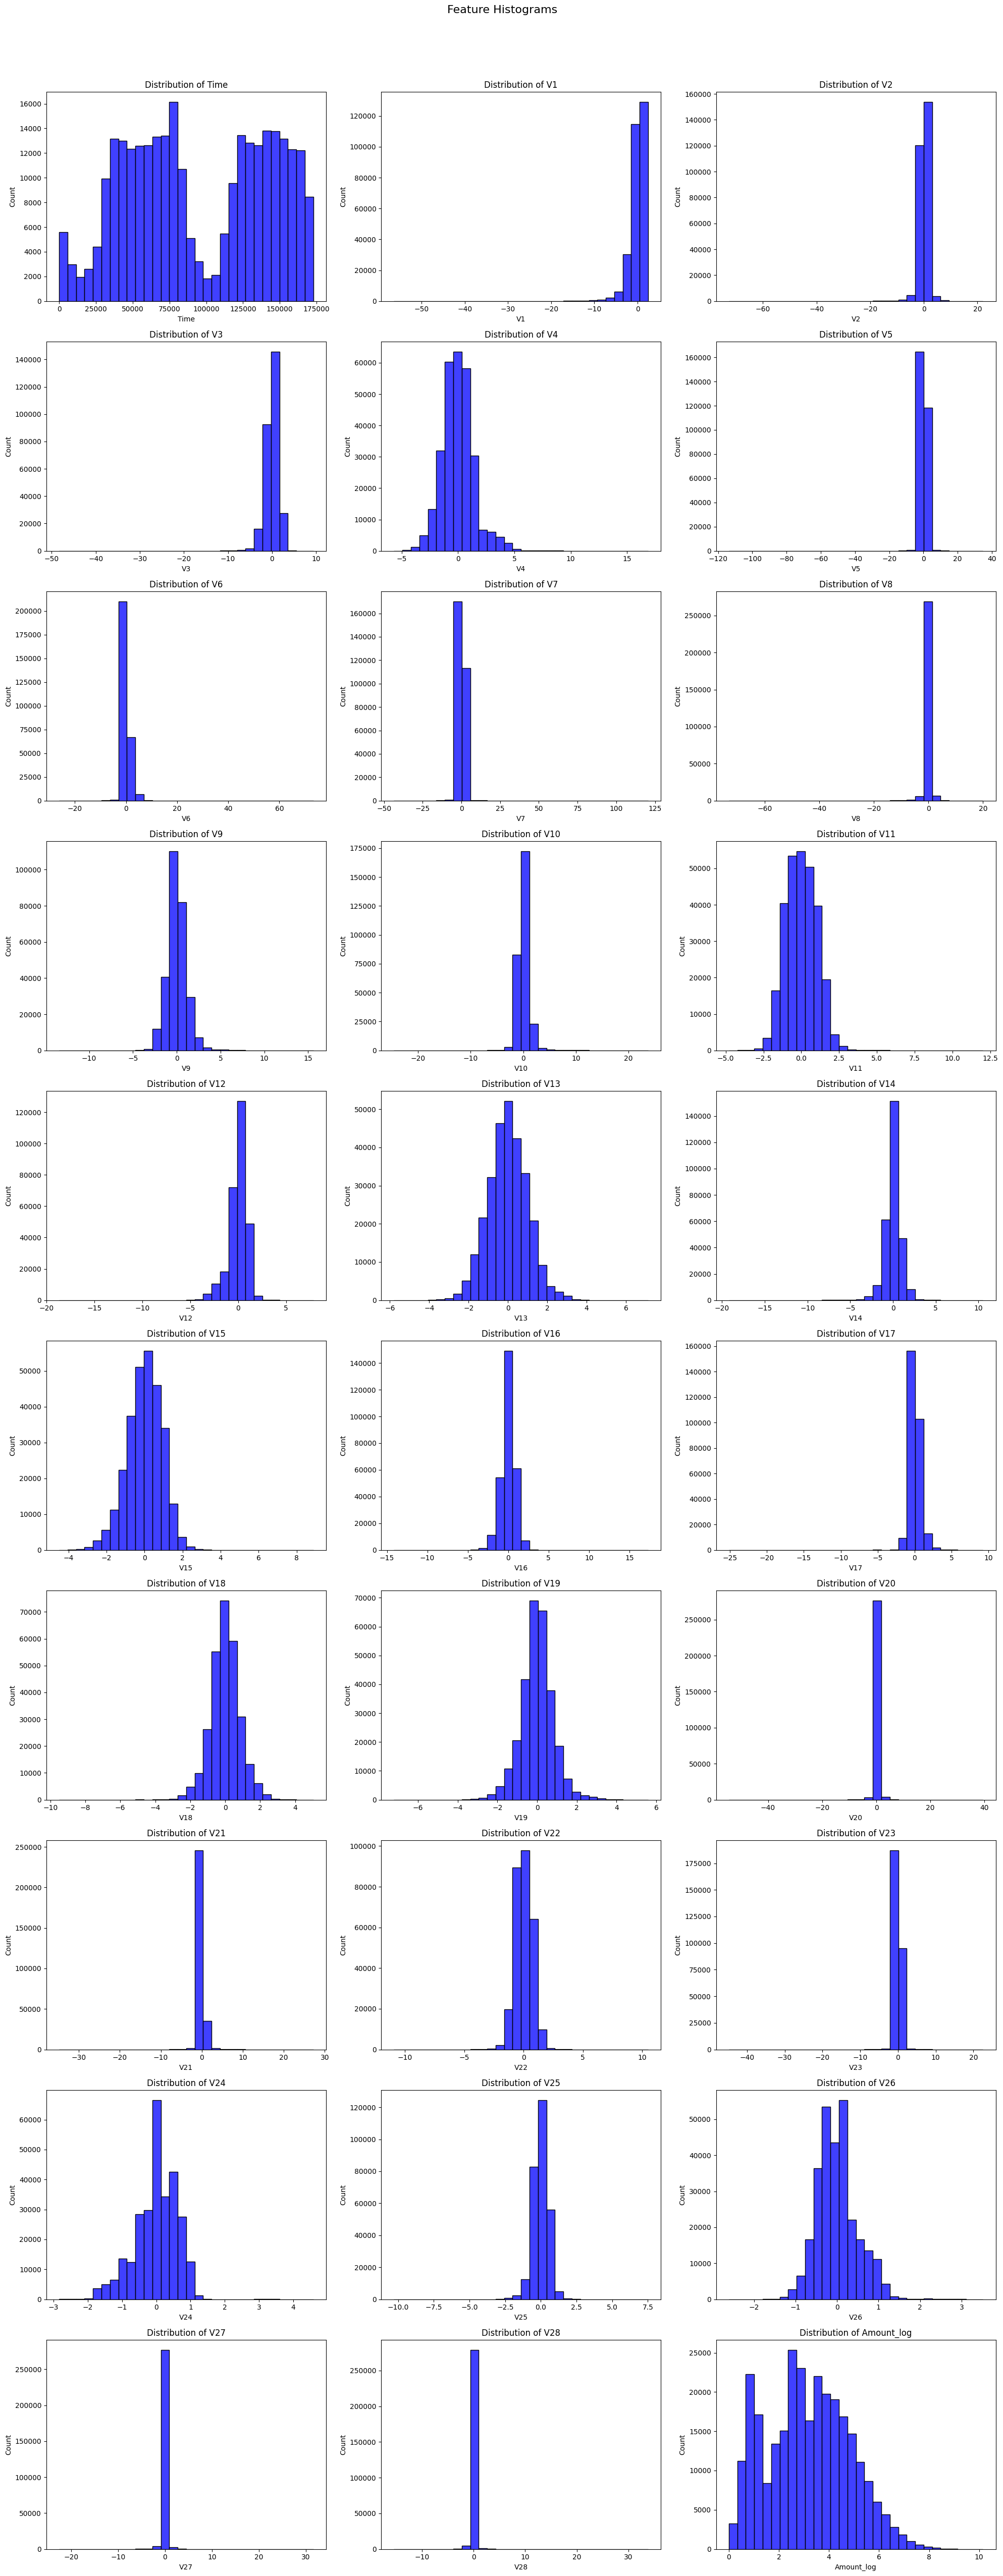

In [10]:
ccfd_df_histogram = X.drop(columns=["Amount"])

# Transform skewed features
ccfd_df_histogram['Amount_log'] = np.log1p(ccfd_df['Amount'])

# Set up the figure and axes
fig, axes = plt.subplots(10, 3, figsize=(20, 50))
axes = axes.flatten()

# Plot each feature
for i, column in enumerate(ccfd_df_histogram.columns):
    if column == 'Amount':  # Use log-transformed data
        sns.histplot(ccfd_df_histogram['Amount_log'], bins=30, color='blue', ax=axes[i])
        axes[i].set_title(f'Distribution of {column} (log-transformed)')
    else:
        sns.histplot(ccfd_df_histogram[column], bins=30, color='blue', ax=axes[i])
        axes[i].set_title(f'Distribution of {column}')

# Adjust layout and title
fig.subplots_adjust(hspace=0.6, wspace=0.4)
plt.suptitle("Feature Histograms", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

## Data Preprocessing

### 4.1 Split data

As this dataset is heavily unbalanced, we will attempt to train both logistic regression and random forest classification models.

We first split the data into train and test sets with an 80:20 split. We additionally stratify the split to ensure the test set maintains a realistic split of fraudulent and non-fraudulent transactions.

In [11]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Check class distribution
print("Training class distribution:")
print(y_train.value_counts(normalize=True))
print("\nTest class distribution:")
print(y_test.value_counts(normalize=True))

Training class distribution:
0    0.998271
1    0.001729
Name: Class, dtype: float64

Test class distribution:
0    0.99828
1    0.00172
Name: Class, dtype: float64


### 4.2 Feature scaling

To prevent the time and amount features from dominating our models, we standardise them. Features V1-28 are already close to standardised and so we omit them from this step.

In [12]:
# Scale the features
scaler = StandardScaler()
X_train[["Time", "Amount"]] = scaler.fit_transform(X_train[["Time", "Amount"]])
X_test[["Time", "Amount"]] = scaler.transform(X_test[["Time", "Amount"]])

### 4.3 Over sampling

Because our data is heavily imbalanced, training models on the raw data would bias the classifier towards the majority class. To address this and ensure our model performs well for both classes (fraudulent and non-fraudulent), we use SMOTE (Synthetic Minority Oversampling Technique). SMOTE generates synthetic samples for the minority (fraudulent) class by interpolating between existing instances.

We can see below that after resampling, our training set contains a balanced split of both target classes.

In [13]:
# Initialize SMOTE
smote = SMOTE(random_state=1)

# Resample the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution after resampling
print("\nTraining class distribution after resampling:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))


Training class distribution after resampling:
0    0.5
1    0.5
Name: Class, dtype: float64


## 5. Training and Evaluating Models

### 5.1 Logistic regression model
We train a logistic regression model on the dataset and evaluate its performance.

The model achieves a recall of 0.92, indicating that it successfully identifies most fraudulent cases. However, its precision is 0.06, showing that many non-fraudulent transactions are incorrectly classified as fraudulent. This low precision highlights a high number of false positives, where the model mislabels legitimate transactions as fraud.

The confusion matrix clearly shows that while the model is effective at detecting fraudulent cases (high recall), it struggles with precision, as the number of false positives exceeds 2,000. This imbalance can lead to poor user experience in real-world applications, as legitimate users may face unnecessary transaction rejections.


Model training complete.

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962



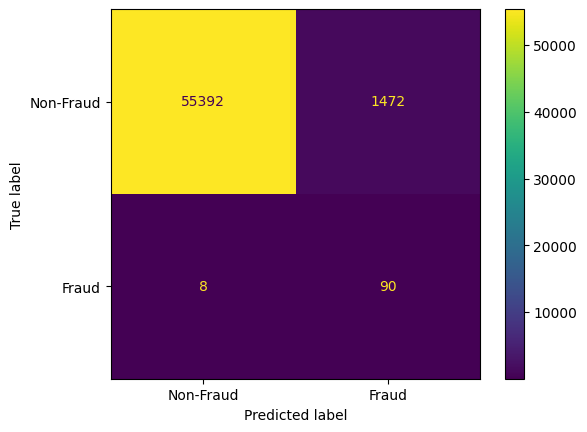

In [14]:
# Initialize and train the model
model = LogisticRegression(random_state=1)
model.fit(X_train_resampled, y_train_resampled)

# Print training complete message
print("\nModel training complete.")

# Predict on the test set
y_pred = model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Fraud", "Fraud"])
disp.plot(cmap='viridis')


### 5.2 Random Forest

When we train and analyze the random forest model, several notable improvements and trade-offs are observed compared to the logistic regression model:

- The precision for fraudulent cases improves significantly, increasing from 0.06 to 0.83, indicating far fewer false positives. This is a substantial improvement, as the model now correctly identifies most non-fraudulent transactions while maintaining good identification of fraudulent cases.
- However, the recall for fraudulent cases decreases slightly from 0.92 to 0.86, meaning the model misses more fraudulent cases compared to the logistic regression model.

When comparing the logistic regression and random forest models, we observe that the random forest model offers a better overall performance for the following reasons:

- The F1-score for the fraudulent class increases significantly in the random forest model (from 0.11 to 0.84). This improvement indicates a better balance between precision and recall, ensuring the model is not overly biased toward one metric.

- The macro average metrics for precision, recall, and F1-score all improve with the random forest model. In particular the macro average of the f1-score increases from 0.55 to 0.93. This improvement reflects the model's ability to perform well across both classes, even with the dataset's significant imbalance.



Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.87      0.86        98

    accuracy                           1.00     56962
   macro avg       0.93      0.93      0.93     56962
weighted avg       1.00      1.00      1.00     56962



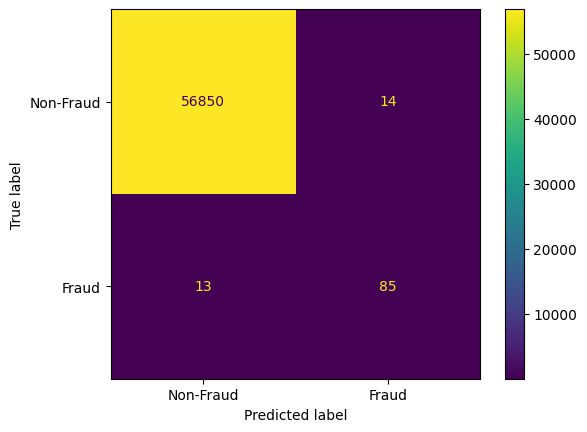

In [15]:
# Initialize and train
rf_model = RandomForestClassifier(n_estimators=20, n_jobs=-1, random_state=1)
rf_model.fit(X_train_resampled, y_train_resampled)

# Evaluate the Random Forest model
y_pred_rf = rf_model.predict(X_test)
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Fraud", "Fraud"])
disp.plot(cmap='viridis')